In [91]:
from iads import loading_data as loader
from iads import traitement_data as traitement

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# I. Chargement des données :

Charger les données de trictrac depuis les fichiers `bson` et créer avec des `dataframe`

- Le fichier `avis.bson`contient la base de données des avis, et `details.bson` celle des jeux

In [92]:
df_jeux = loader.load_dataframe("details.bson")

In [93]:
df_avis = loader.load_dataframe("avis.bson")

# Exploration et traitement des données :

# I. Traitements basiques : 

## 1. Données des jeux (`details.bson`) :

In [94]:
df_jeux.head(n=2)

,Nombre d'avis,full_title,casting,Note rectifiée,_id,Note,url,Note Finkel,categories,Nombre d'avis rectifiés,description,gameplay,titre
0,19.0,Marvel United (2020),Par Eric Lang et Andrea ChiarvesioIllustré par...,8.40,63c5790a08b9fb9fd8f26ec8,7.58,https://www.trictrac.net/jeu-de-societe/marvel...,8.74,NaN,10.0,\n Marvel United : Unis c...,1 à 4|14 ans et +|45,Marvel United
1,33.0,Mariposas (2020),Par Elizabeth HargraveIllustré par Matt Paquet...,7.29,63c5790a08b9fb9fd8f26ec9,7.39,https://www.trictrac.net/jeu-de-societe/mariposas,7.68,NaN,17.0,"\n Chaque année, au print...",2 à 5|14 ans et +|60,Mariposas


In [95]:
df_jeux.shape

(20234, 13)

In [96]:
df_jeux.columns

Index(['Nombre d'avis', 'full_title', 'casting', 'Note rectifiée', '_id',
       'Note', 'url', 'Note Finkel', 'categories', 'Nombre d'avis rectifiés',
       'description', 'gameplay', 'titre'],
      dtype='object')

### 1.1 Identifiant et titre d'un jeu :

La base de données est scrappée depuis le site <https://www.trictrac.net>, l'attribut `_id` est généré lors du scrapping.

Si un jeu est scrappé 2 fois, il sera duplicé dans la base de données avec une valeur de `_id` différente.

- On supprime l'attribut `_id` pour souligner la duplication de jeux et pouvoir la retirer.

In [97]:
df_jeux.head(1)

,Nombre d'avis,full_title,casting,Note rectifiée,_id,Note,url,Note Finkel,categories,Nombre d'avis rectifiés,description,gameplay,titre
0,19.0,Marvel United (2020),Par Eric Lang et Andrea ChiarvesioIllustré par...,8.4,63c5790a08b9fb9fd8f26ec8,7.58,https://www.trictrac.net/jeu-de-societe/marvel...,8.74,NaN,10.0,\n Marvel United : Unis c...,1 à 4|14 ans et +|45,Marvel United


In [98]:
df_jeux_up = df_jeux.drop(["_id"], axis=1)

In [99]:
df_jeux_up.head(1)

,Nombre d'avis,full_title,casting,Note rectifiée,Note,url,Note Finkel,categories,Nombre d'avis rectifiés,description,gameplay,titre
0,19.0,Marvel United (2020),Par Eric Lang et Andrea ChiarvesioIllustré par...,8.4,7.58,https://www.trictrac.net/jeu-de-societe/marvel...,8.74,NaN,10.0,\n Marvel United : Unis c...,1 à 4|14 ans et +|45,Marvel United


**- Comptage du nombre d'occurrences de chaque ligne (jeu) du dataframe**

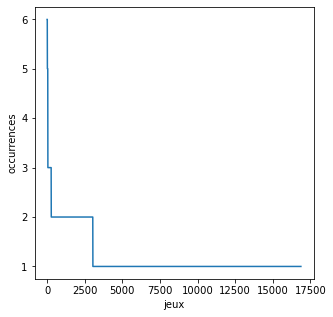

In [100]:
uniques_row = df_jeux_up.value_counts(dropna=False)

plt.figure(figsize=(5, 5))
plt.plot(uniques_row.values)
plt.xlabel("jeux")
plt.ylabel("occurrences")
plt.show()

- On note l'existence de jeux duppliqués dans la base de données.

In [101]:
print("On a", np.where(uniques_row.values != 1, 1, 0).sum(), "jeux duppliqués")

On a 3029 jeux duppliqués


**- Suppression des duplicatas**

In [102]:
df_jeux_up = df_jeux_up.drop_duplicates()

In [103]:
len_before = len(df_jeux)
len_after  = len(df_jeux_up)

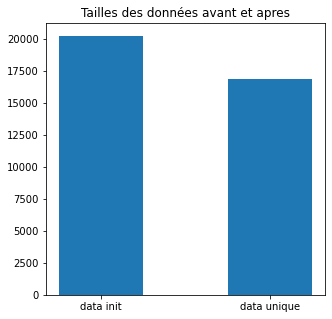

In [104]:
plt.figure(figsize=(5, 5))
plt.bar(['data init', 'data unique'], [len_before, len_after], width=0.5)
plt.title("Tailles des données avant et apres")
plt.show()

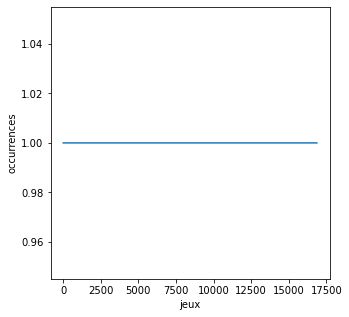

In [105]:
uniques_row = df_jeux_up.value_counts(dropna=False)

plt.figure(figsize=(5, 5))
plt.plot(uniques_row.values)
plt.xlabel("jeux")
plt.ylabel("occurrences")
plt.show()

**- Création d'un nouvel identifiant**

- L'attribut `titre` peut servir d'identifiant pour les jeux, s'il est unique

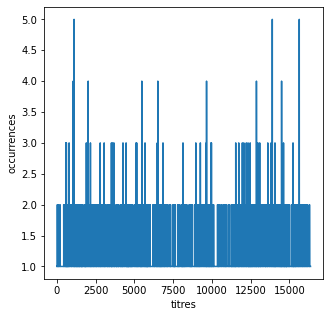

In [106]:
val, counts = np.unique(df_jeux_up["titre"], return_counts=True)

plt.figure(figsize=(5, 5))
plt.plot(counts)
plt.xlabel("titres")
plt.ylabel("occurrences")
plt.show()

On remarque que le titre n'est pas unique dans la base de données.

In [107]:
list_same_title = []

for v in val[counts != 1]:
    a = df_jeux_up[df_jeux_up["titre"] == v]
    
    if len(a) > 1:
        list_same_title.append(a)

In [108]:
list_same_title[3].head()

,Nombre d'avis,full_title,casting,Note rectifiée,Note,url,Note Finkel,categories,Nombre d'avis rectifiés,description,gameplay,titre
18526,2.0,1853 (2009),Par Francis TreshamIllustré par Klemens FranzÉ...,8.0,9.0,https://www.trictrac.net/jeu-de-societe/1853-0,8.03,Jeux de plateau,1.0,\n Aucune description\n ...,3 à 6|12 ans et +|240,1853
18587,0.0,1853 (1989),De Francis TreshamÉdité par Hartland Trefoil,0.0,0.0,https://www.trictrac.net/jeu-de-societe/1853,0.00,Jeux de plateau,0.0,\n Un jeu dans la pure li...,3 à 6|12 ans et +|240,1853


La répétition du titre dans la base de données est causée par l'existence des versions d'un jeu, ainsi deux versions d'un jeu ont le même titre.

Pour créer un identifiant suffit d'inclure la version du jeu dans le titre, et si on regard bien la version est présente dans l'url du jeu

In [109]:
df_jeux_up["_id"] = df_jeux_up.apply(traitement.update_title, axis=1)

In [110]:
df_jeux_up[df_jeux_up["titre"] == "1830"]

,Nombre d'avis,full_title,casting,Note rectifiée,Note,url,Note Finkel,categories,Nombre d'avis rectifiés,description,gameplay,titre,_id
8969,1.0,1830 (1980),Par Charles TurquinIllustré par Patrice Cource...,5.4,5.40,https://www.trictrac.net/jeu-de-societe/1830-0,5.40,Jeux de plateau,1.0,\n Emeutes à Bruxelles. L...,2 à 4|10 ans et +|~,1830,1830-0
19887,19.0,1830 (1986),De Francis TreshamÉdité par Avalon Hill,9.0,8.95,https://www.trictrac.net/jeu-de-societe/1830,9.48,Jeux de plateau|Bourse & finances|Construction...,12.0,\n Nous sommes à la fin d...,3 à 6|15 à 99 |300,1830,1830


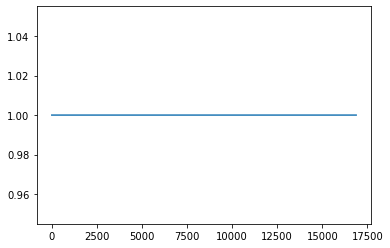

In [111]:
val, counts = np.unique(df_jeux_up["_id"], return_counts=True)

plt.plot(counts)
plt.show()

- Ainsi on a un attribut unique pour identifier un jeu

### 1.2 Castings :

In [112]:
df_jeux_up.head(3)["casting"]

0    Par Eric Lang et Andrea ChiarvesioIllustré par...
1    Par Elizabeth HargraveIllustré par Matt Paquet...
2    Par Alexandre GarciaIllustré par Nastya LehnÉd...
Name: casting, dtype: object

- Les castings d'un jeu sont l'ensemble de ses créateurs, illustrateurs, éditeurs et distributeurs

On décompose l'attribut `casting` pour récupérer ces informations

In [113]:
df_jeux_up["creators"] = df_jeux_up.apply(traitement.extract_creators, axis=1)
df_jeux_up["illustrators"] = df_jeux_up.apply(traitement.extract_illustrators, axis=1)
df_jeux_up["editors"] = df_jeux_up.apply(traitement.extract_editors, axis=1)
df_jeux_up["distributors"] = df_jeux_up.apply(traitement.extract_distributors, axis=1)

In [114]:
df_jeux_up.head(3)

,Nombre d'avis,full_title,casting,Note rectifiée,Note,url,Note Finkel,categories,Nombre d'avis rectifiés,description,gameplay,titre,_id,creators,illustrators,editors,distributors
0,19.0,Marvel United (2020),Par Eric Lang et Andrea ChiarvesioIllustré par...,8.40,7.58,https://www.trictrac.net/jeu-de-societe/marvel...,8.74,NaN,10.0,\n Marvel United : Unis c...,1 à 4|14 ans et +|45,Marvel United,marvel-united,Eric Lang et Andrea Chiarvesio,Édouard Guiton,CMON Limited,NaN
1,33.0,Mariposas (2020),Par Elizabeth HargraveIllustré par Matt Paquet...,7.29,7.39,https://www.trictrac.net/jeu-de-societe/mariposas,7.68,NaN,17.0,"\n Chaque année, au print...",2 à 5|14 ans et +|60,Mariposas,mariposas,Elizabeth Hargrave,Matt Paquette et Indi Maverick,Gigamic,NaN
2,28.0,Quetzal (2020),Par Alexandre GarciaIllustré par Nastya LehnÉd...,7.22,8.18,https://www.trictrac.net/jeu-de-societe/quetzal,7.42,Enchères|Aventures dans la jungle|Collection /...,9.0,\n Vous êtes à la tête d’...,2 à 5|8 ans et +|45,Quetzal,quetzal,Alexandre Garcia,Nastya Lehn,Gigamic,NaN


### 1.3 gameplay :

In [115]:
df_jeux_up.head(3)["gameplay"]

0    1 à 4|14 ans et +|45 
1    2 à 5|14 ans et +|60 
2     2 à 5|8 ans et +|45 
Name: gameplay, dtype: object

Le gameplay d'un jeu est sous la forme : Nombre joueur | âge requis | durée d'une partie

In [116]:
df_jeux_up["nb_players"] = df_jeux_up.apply(traitement.extract_players, axis=1)
df_jeux_up["age_required"] = df_jeux_up.apply(traitement.extract_ages, axis=1)
df_jeux_up["duration"] = df_jeux_up.apply(traitement.extract_duration, axis=1)

In [117]:
df_jeux_up.head(3)

,Nombre d'avis,full_title,casting,Note rectifiée,Note,url,Note Finkel,categories,Nombre d'avis rectifiés,description,gameplay,titre,_id,creators,illustrators,editors,distributors,nb_players,age_required,duration
0,19.0,Marvel United (2020),Par Eric Lang et Andrea ChiarvesioIllustré par...,8.40,7.58,https://www.trictrac.net/jeu-de-societe/marvel...,8.74,NaN,10.0,\n Marvel United : Unis c...,1 à 4|14 ans et +|45,Marvel United,marvel-united,Eric Lang et Andrea Chiarvesio,Édouard Guiton,CMON Limited,NaN,1-4,14-99,45.0
1,33.0,Mariposas (2020),Par Elizabeth HargraveIllustré par Matt Paquet...,7.29,7.39,https://www.trictrac.net/jeu-de-societe/mariposas,7.68,NaN,17.0,"\n Chaque année, au print...",2 à 5|14 ans et +|60,Mariposas,mariposas,Elizabeth Hargrave,Matt Paquette et Indi Maverick,Gigamic,NaN,2-5,14-99,60.0
2,28.0,Quetzal (2020),Par Alexandre GarciaIllustré par Nastya LehnÉd...,7.22,8.18,https://www.trictrac.net/jeu-de-societe/quetzal,7.42,Enchères|Aventures dans la jungle|Collection /...,9.0,\n Vous êtes à la tête d’...,2 à 5|8 ans et +|45,Quetzal,quetzal,Alexandre Garcia,Nastya Lehn,Gigamic,NaN,2-5,8-99,45.0


### 1.4 Suppression des attributs inutiles :

Les attributs `url`, `casting`, `gameplay` sont traités, ils ne sont donc plus nécessaires.

In [118]:
df_jeux_up = df_jeux_up.drop(["url", "casting", "gameplay"], axis=1)

In [119]:
df_jeux_up.head(2)

,Nombre d'avis,full_title,Note rectifiée,Note,Note Finkel,categories,Nombre d'avis rectifiés,description,titre,_id,creators,illustrators,editors,distributors,nb_players,age_required,duration
0,19.0,Marvel United (2020),8.40,7.58,8.74,NaN,10.0,\n Marvel United : Unis c...,Marvel United,marvel-united,Eric Lang et Andrea Chiarvesio,Édouard Guiton,CMON Limited,NaN,1-4,14-99,45.0
1,33.0,Mariposas (2020),7.29,7.39,7.68,NaN,17.0,"\n Chaque année, au print...",Mariposas,mariposas,Elizabeth Hargrave,Matt Paquette et Indi Maverick,Gigamic,NaN,2-5,14-99,60.0


## 2. Données des avis (`avis.bson`) :

In [120]:
df_avis.head(2)

,comment,date_published,_id,title_review,url,title,note,review_href,author,treated
0,"Lorsque le jeu est jeu, bon, réflexif, joli po...",2021-01-27 11:06:44,63c6726ea81f3e3016af9a56,Voyages sur les ailes des papillons,https://www.trictrac.net/jeu-de-societe/maripo...,Mariposas,8.0,https://www.trictrac.net/avis/vraiment-bon-12514,Monsieur Guillaume,True
1,Comment continuer après un mega hit ? Simpleme...,2020-10-18 10:04:21,63c6726ea81f3e3016af9a57,le festival de Michoacan,https://www.trictrac.net/jeu-de-societe/maripo...,Mariposas,7.0,https://www.trictrac.net/avis/le-festival-de-m...,morlockbob,True


In [121]:
df_avis.shape

(246524, 10)

In [122]:
df_avis.columns

Index(['comment', 'date_published', '_id', 'title_review', 'url', 'title',
       'note', 'review_href', 'author', 'treated'],
      dtype='object')

### 2.1 Identifiant d'un avis :

Comme pour les jeux, l'attribut `_id` est généré lors du scrapping,il souffre du même problème.

In [123]:
df_avis.head(1)

,comment,date_published,_id,title_review,url,title,note,review_href,author,treated
0,"Lorsque le jeu est jeu, bon, réflexif, joli po...",2021-01-27 11:06:44,63c6726ea81f3e3016af9a56,Voyages sur les ailes des papillons,https://www.trictrac.net/jeu-de-societe/maripo...,Mariposas,8.0,https://www.trictrac.net/avis/vraiment-bon-12514,Monsieur Guillaume,True


In [124]:
df_avis_up = df_avis.drop(["_id"], axis=1)

In [125]:
df_avis_up.head(1)

,comment,date_published,title_review,url,title,note,review_href,author,treated
0,"Lorsque le jeu est jeu, bon, réflexif, joli po...",2021-01-27 11:06:44,Voyages sur les ailes des papillons,https://www.trictrac.net/jeu-de-societe/maripo...,Mariposas,8.0,https://www.trictrac.net/avis/vraiment-bon-12514,Monsieur Guillaume,True


**- Comptage du nombre d'occurrences de chaque ligne (avis) du dataframe**

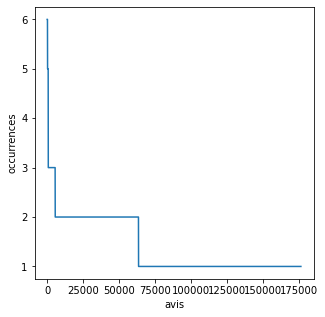

In [126]:
uniques_row = df_avis_up.value_counts(dropna=False)

plt.figure(figsize=(5, 5))
plt.plot(uniques_row.values)
plt.xlabel("avis")
plt.ylabel("occurrences")
plt.show()

- On note l'existence d'avis duppliqués dans la base de données.

In [127]:
print("On a", np.where(uniques_row.values != 1, 1, 0).sum(), "avis duppliqués")

On a 63375 avis duppliqués


**- Suppression des duplicatas**

In [128]:
df_avis_up = df_avis_up.drop_duplicates()

In [129]:
len_before = len(df_avis)
len_after  = len(df_avis_up)

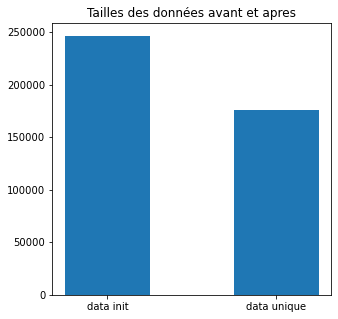

In [130]:
plt.figure(figsize=(5, 5))
plt.bar(['data init', 'data unique'], [len_before, len_after], width=0.5)
plt.title("Tailles des données avant et apres")
plt.show()

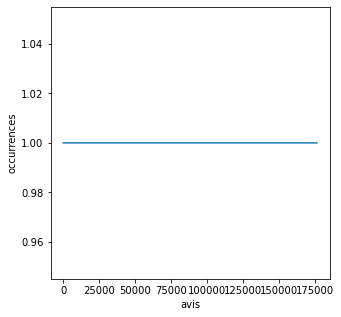

In [131]:
uniques_row = df_avis_up.value_counts(dropna=False)

plt.figure(figsize=(5, 5))
plt.plot(uniques_row.values)
plt.xlabel("avis")
plt.ylabel("occurrences")
plt.show()

### 2.2 Référence vers le jeu dans l'avis :

Comme l'identifiant d'un jeu est maintenant son titre et sa version, afin de conserver une base de données relationnelle nous devons adapter la référence au jeu dans la revue.

In [132]:
df_avis_up["title_id_jeu"] = df_avis_up.apply(traitement.update_title, axis=1)

In [133]:
np.unique(df_avis_up[df_avis_up["title"] == "1830"]["title_id_jeu"])

array(['1830', '1830-0'], dtype=object)

In [134]:
print("Nombre de jeux sans version ", len(np.unique(df_avis_up["title"])))
print("Nombre de jeux avec version ", len(np.unique(df_avis_up["title_id_jeu"])))

Nombre de jeux sans version  10709
Nombre de jeux avec version  10936


### 2.3 Suppression des attributs inutiles :

On drop les attributs `url` et `review_href` car ils ne nous seront plus utiles.

In [135]:
df_avis_up = df_avis_up.drop(["url", "review_href" ], axis=1)

In [136]:
df_avis_up.head(2)

,comment,date_published,title_review,title,note,author,treated,title_id_jeu
0,"Lorsque le jeu est jeu, bon, réflexif, joli po...",2021-01-27 11:06:44,Voyages sur les ailes des papillons,Mariposas,8.0,Monsieur Guillaume,True,mariposas
1,Comment continuer après un mega hit ? Simpleme...,2020-10-18 10:04:21,le festival de Michoacan,Mariposas,7.0,morlockbob,True,mariposas


### 2.4 Date de publication :

On garde seulement l'année de publication

In [137]:
df_avis_up["date_published"] = df_avis_up.apply(traitement.extract_published_year, axis=1)

In [138]:
df_avis_up.head(2)

,comment,date_published,title_review,title,note,author,treated,title_id_jeu
0,"Lorsque le jeu est jeu, bon, réflexif, joli po...",2021,Voyages sur les ailes des papillons,Mariposas,8.0,Monsieur Guillaume,True,mariposas
1,Comment continuer après un mega hit ? Simpleme...,2020,le festival de Michoacan,Mariposas,7.0,morlockbob,True,mariposas


# II. Traitements avancés :

## 1. Clustering des catégories d'un jeu :

L'attribut `categories` d'un jeu est une suite de catégories séparées par des '|'

In [139]:
categories = df_jeux_up.apply(traitement.extract_categories, axis=1)

In [140]:
categories[4]

array(['Card-driven', 'Combinaison', 'Coopération', 'Deck building',
       'Locomotion & voyage', 'Humour', 'Gestion', 'Science fiction'],
      dtype='<U19')

In [141]:
all_categories = []
for cat in categories:
    all_categories.extend(cat)

In [142]:
print("En moyenne", len(all_categories) / len(df_jeux_up), "categorie par jeu")

En moyenne 1.5693711847330054 categorie par jeu


In [143]:
uniq_cats, counts = np.unique(all_categories, return_counts=True)

- Nous pourrions faire un codage `one-hot` pour représenter les catégories, mais nous avons 184 catégories différentes, ce qui est énorme. Nous allons essayer de créer des clusters pour diminuer le nombre possible de catégories.

In [144]:
len(uniq_cats)

184

### 1.1 Word cloud des catégories :

In [145]:
from wordcloud import WordCloud

In [146]:
index_sort = counts.argsort()[::-1]
counts = counts[index_sort]
uniq_cats = uniq_cats[index_sort]

dico_categories = dict()

for i in range(len(uniq_cats)):
    cat = uniq_cats[i]
    dico_categories[cat] = counts[i]

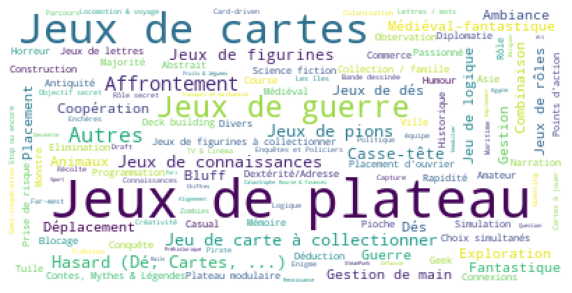

In [147]:
wordcloud = WordCloud(background_color='white', stopwords =[], max_words=len(uniq_cats)).generate_from_frequencies(dico_categories)    

plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

- On remarque que la distribution des catégories suit une loi de Zipf

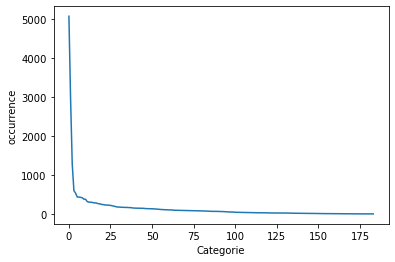

In [148]:
plt.plot(counts)
plt.xlabel("Categorie")
plt.ylabel("occurrence")
plt.show()

In [149]:
N = 10
for i in range(N):
    print(f"{i} - {uniq_cats[i]} : {counts[i]}")

0 - Jeux de plateau : 5081
1 - Jeux de cartes : 2956
2 - Jeux de guerre : 1279
3 - Autres : 599
4 - Affrontement : 535
5 - Jeu de carte à collectionner : 436
6 - Jeux de connaissances : 433
7 - Hasard (Dé, Cartes, ...) : 427
8 - Jeux de pions : 416
9 - Casse-tête : 380


### 1.2 Traitement des mots :

In [150]:
from nltk.corpus import stopwords
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import cluster

In [151]:
nlp = spacy.load('fr_core_news_md')

**On lemmatise les noms des catégories, ainsi obtenir des noms simple**

In [152]:
uniq_cats_lemma = []
for cat in uniq_cats:
    doc = nlp(str(cat))
    
    new_cat = ""
    for token in doc:
        new_cat += token.lemma_ + " "
        
    uniq_cats_lemma.append(new_cat.strip())

uniq_cats = uniq_cats_lemma

**On supprime les stops words**

In [153]:
sw = stopwords.words('french') + ["jeu", "être", "avoir", "plus", "tout", "très"] 

In [154]:
vectorizer = TfidfVectorizer(use_idf=False, stop_words=sw)

In [155]:
X = vectorizer.fit_transform(uniq_cats)

- Les mots se trouvant dans les catégories : 

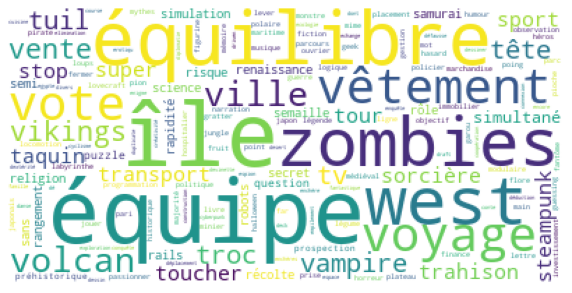

In [156]:
dico_cat = vectorizer.vocabulary_
wordcloud = WordCloud(background_color="white", max_words=len(dico_cat)).generate_from_frequencies(dico_cat)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**Clustering**

In [157]:
import re
uniq_cats_sw = []

for cat in uniq_cats:
    words = cat.lower()
    words = re.split("[ -]+", words)
    new_cat = ""
    
    for w in words:
        if w in vectorizer.vocabulary_:
            new_cat += str(w) + " "
        
    new_cat = new_cat.strip()
    if new_cat == "":
        print(cat)
        continue
        
    uniq_cats_sw.append(new_cat)

uniq_cats = uniq_cats_sw

***1. Avec AffinityPropagation :***

In [158]:
clu = cluster.AffinityPropagation()

In [159]:
pred = clu.fit_predict(X)

In [160]:
print("Nombre de clusters trouvés :", max(pred))

Nombre de clusters trouvés : 28


- On réccupere les clusters générés

In [161]:
clusters = {}

for i in range(len(pred)):
    p = pred[i]
    
    if p not in clusters:
        clusters[p] = []
    
    clusters[p].append(uniq_cats[i])

**wordCloud de chaque cluster :**

In [162]:
nb_clus = len(clusters)

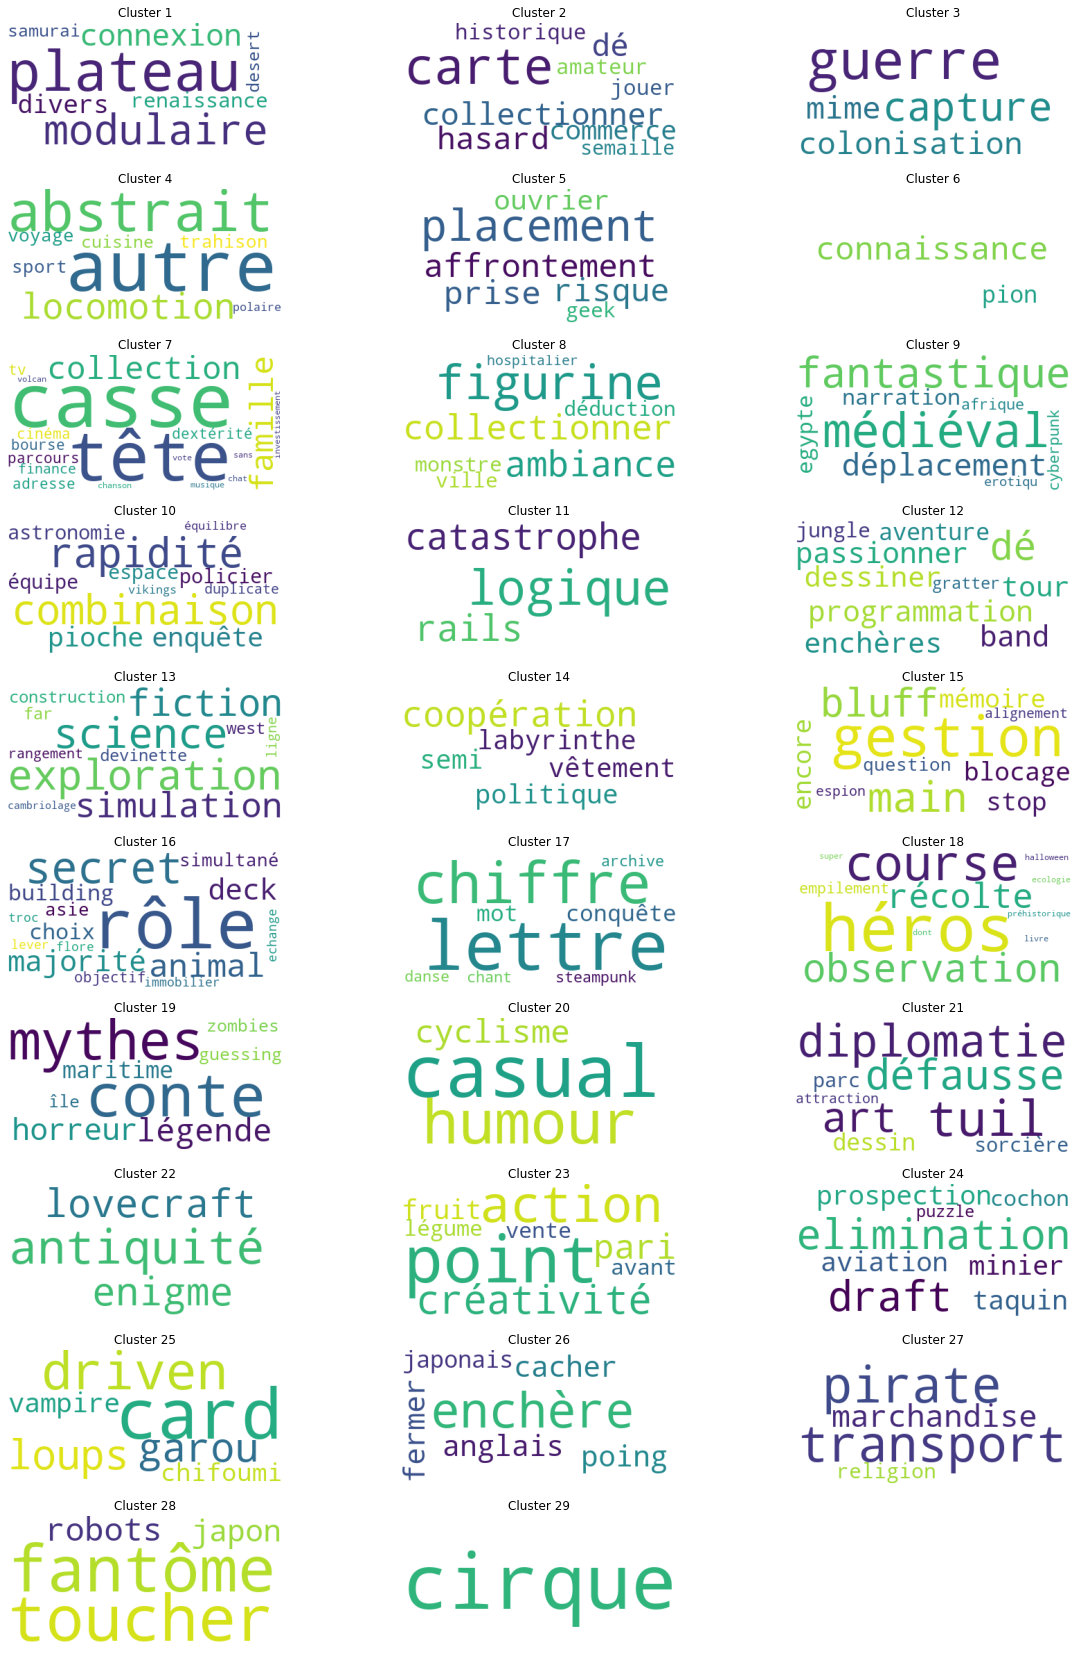

In [163]:
plt.figure(figsize=(20, 30))
i = 1
for c in clusters:
    corpus = " ".join(clusters[c])
    wordcloud = WordCloud(background_color='white', max_words=len(uniq_cats)).generate(corpus) 
    plt.subplot(nb_clus // 3 + 1, 3, i)
    plt.title(f"Cluster {i}")
    plt.imshow(wordcloud)
    plt.axis('off')
    i += 1

# III. Statistiques :

## 1. Notes

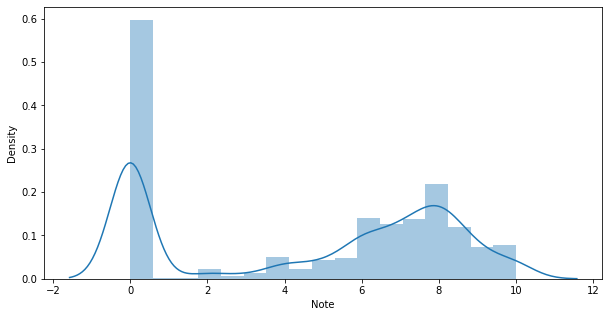

In [164]:
plt.figure(figsize=(10, 5))
notes = df_jeux_up["Note"]

sns.distplot(notes)
plt.show()

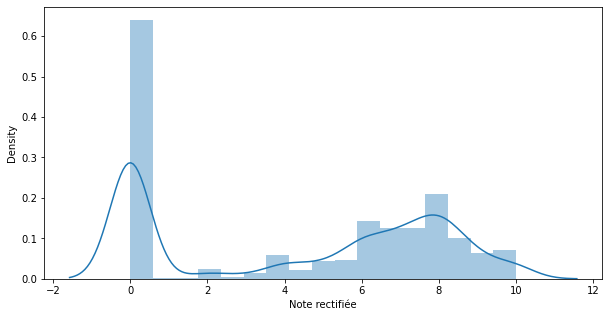

In [165]:
plt.figure(figsize=(10, 5))
notes = df_jeux_up["Note rectifiée"]

sns.distplot(notes)
plt.show()

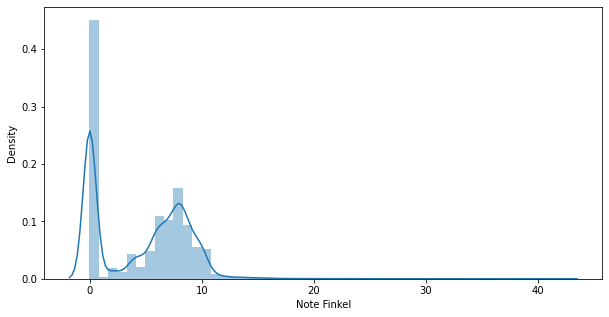

In [166]:
plt.figure(figsize=(10, 5))
notes = df_jeux_up["Note Finkel"]

sns.distplot(notes)
plt.show()

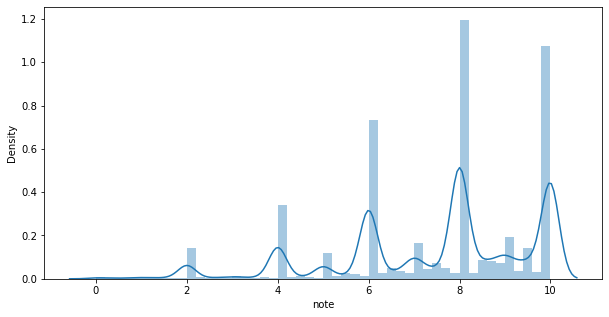

In [167]:
plt.figure(figsize=(10, 5))
notes = df_avis_up["note"]

sns.distplot(notes)
plt.show()

## 2. Date des avis

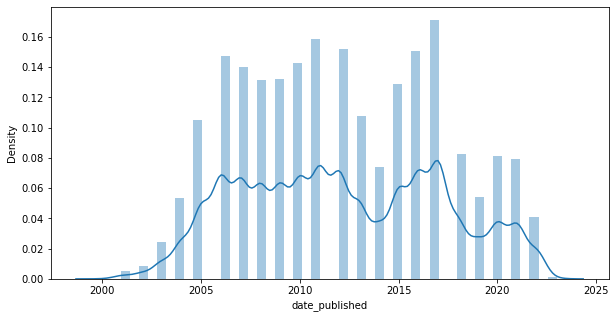

In [168]:
plt.figure(figsize=(10, 5))
notes = df_avis_up["date_published"]

sns.distplot(notes)
plt.show()

## 3. Mots fréquents selon les notes :

In [169]:
comments_df = df_avis_up[df_avis_up["comment"].notna()]

In [170]:
notes_int = comments_df["note"] // 1

In [171]:
words_notes = {}

for note in range(11):
    words_notes[note] = np.array(comments_df[notes_int == note]["comment"])

In [172]:
def get_wordcloud(data, stop_words):
    vectorizer = TfidfVectorizer(use_idf=False, stop_words=stop_words)
    vectors = vectorizer.fit_transform(data)

    counts = np.array(vectors.sum(axis=0))[0]

    dico = dict()
    words = vectorizer.get_feature_names()

    for i in range(len(words)):
        w = words[i]
        dico[w] = counts[i]

    return WordCloud(background_color='white', stopwords=stop_words, max_words=100).generate_from_frequencies(dico) 


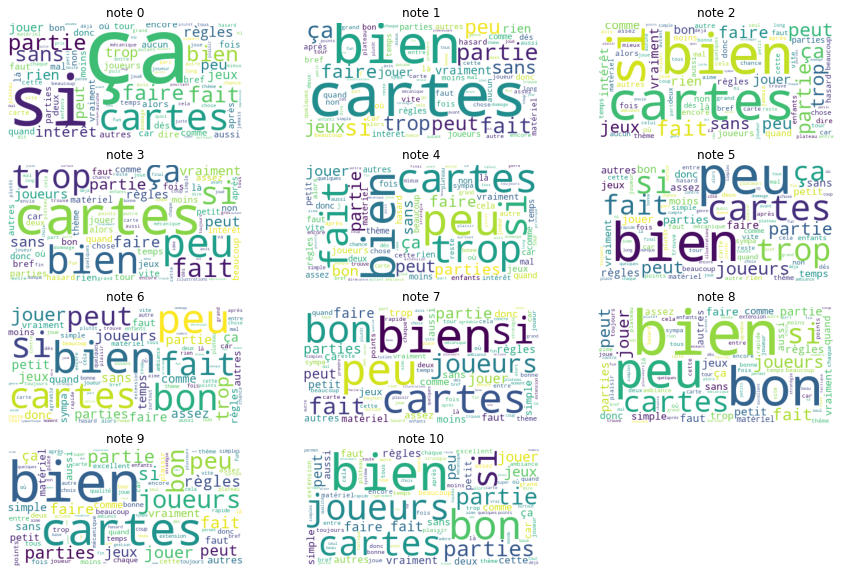

In [173]:
plt.figure(figsize=(15, 10))

for note in words_notes:
    wordcloud = get_wordcloud(words_notes[note], sw) 
    plt.subplot(4, 3, note + 1)
    plt.title(f"note {note}")
    plt.imshow(wordcloud)
    plt.axis('off')